# How to add dynamic breakpoints

!!! note
    For **human-in-the-loop** workflows use the new [`interrupt()`](/langgraphjs/reference/functions/langgraph.interrupt-1.html) function for **human-in-the-loop** workflows. Please review the [Human-in-the-loop conceptual guide](/langgraphjs/concepts/human_in_the_loop) for more information about design patterns with `interrupt`.

!!! tip "Prerequisites"
    This guide assumes familiarity with the following concepts:

    * [Breakpoints](/langgraphjs/concepts/breakpoints)
    * [LangGraph Glossary](/langgraphjs/concepts/low_level)

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). [Breakpoints](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#breakpoints) are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding (e.g., for sensitive actions).

In LangGraph you can add breakpoints before / after a node is executed. But oftentimes it may be helpful to **dynamically** interrupt the graph from inside a given node based on some condition. When doing so, it may also be helpful to include information about **why** that interrupt was raised.

This guide shows how you can dynamically interrupt the graph using `NodeInterrupt` -- a special exception that can be raised from inside a node. Let's see it in action!

### Define the graph

In [1]:
import {
  Annotation,
  MemorySaver,
  NodeInterrupt,
  StateGraph,
} from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  input: Annotation<string>,
});

const step1 = async (state: typeof StateAnnotation.State) => {
  console.log("---Step 1---");
  return state;
};

const step2 = async (state: typeof StateAnnotation.State) => {
  // Let's optionally raise a NodeInterrupt
  // if the length of the input is longer than 5 characters
  if (state.input?.length > 5) {
    throw new NodeInterrupt(`Received input that is longer than 5 characters: ${state.input}`);
  }
  console.log("---Step 2---");
  return state;
};

const step3 = async (state: typeof StateAnnotation.State) => {
  console.log("---Step 3---");
  return state;
};

const checkpointer = new MemorySaver();

const graph = new StateGraph(StateAnnotation)
  .addNode("step1", step1)
  .addNode("step2", step2)
  .addNode("step3", step3)
  .addEdge("__start__", "step1")
  .addEdge("step1", "step2")
  .addEdge("step2", "step3")
  .addEdge("step3", "__end__")
  .compile({ checkpointer });

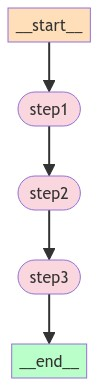

In [2]:
import * as tslab from "tslab";

const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

### Run the graph with dynamic interrupt

First, let's run the graph with an input that's <= 5 characters long. This should safely ignore the interrupt condition we defined and return the original input at the end of the graph execution.

In [3]:
const initialInput = { input: "hello" };
const config = {
  configurable: {
    thread_id: "1",
  },
  streamMode: "values" as const,
};

const stream = await graph.stream(initialInput, config);

for await (const event of stream) {
  console.log(event);
}

{ input: 'hello' }
---Step 1---
{ input: 'hello' }
---Step 2---
{ input: 'hello' }
---Step 3---
{ input: 'hello' }


If we inspect the graph at this point, we can see that there are no more tasks left to run and that the graph indeed finished execution.

In [4]:
const state = await graph.getState(config);
console.log(state.next);
console.log(state.tasks);

[]
[]


Now, let's run the graph with an input that's longer than 5 characters. This should trigger the dynamic interrupt we defined via raising a `NodeInterrupt` error inside the `step2` node.

In [5]:
const longInput = { input: "hello world" };
const config2 = {
  configurable: {
    thread_id: "2",
  },
  streamMode: "values" as const,
};

const streamWithInterrupt = await graph.stream(longInput, config2);

for await (const event of streamWithInterrupt) {
  console.log(event);
}

{ input: 'hello world' }
---Step 1---
{ input: 'hello world' }


We can see that the graph now stopped while executing `step2`. If we inspect the graph state at this point, we can see the information on what node is set to execute next (`step2`), as well as what node raised the interrupt (also `step2`), and additional information about the interrupt.

In [6]:
const state2 = await graph.getState(config2);
console.log(state2.next);
console.log(JSON.stringify(state2.tasks, null, 2));

[ 'step2' ]
[
  {
    "id": "c91a38f7-2aec-5c38-a3f0-60fba6efe73c",
    "name": "step2",
    "interrupts": [
      {
        "value": "Received input that is longer than 5 characters: hello world",
        "when": "during"
      }
    ]
  }
]


If we try to resume the graph from the breakpoint, we will simply interrupt again as our inputs & graph state haven't changed.

In [7]:
// NOTE: to resume the graph from a dynamic interrupt we use the same syntax as
// regular interrupts -- we pass null as the input
const resumedStream = await graph.stream(null, config2);

for await (const event of resumedStream) {
  console.log(event);
}

In [8]:
const state3 = await graph.getState(config2);
console.log(state3.next);
console.log(JSON.stringify(state2.tasks, null, 2));

[ 'step2' ]
[
  {
    "id": "c91a38f7-2aec-5c38-a3f0-60fba6efe73c",
    "name": "step2",
    "interrupts": [
      {
        "value": "Received input that is longer than 5 characters: hello world",
        "when": "during"
      }
    ]
  }
]


### Update the graph state

To get around it, we can do several things. 

First, we could simply run the graph on a different thread with a shorter input, like we did in the beginning. Alternatively, if we want to resume the graph execution from the breakpoint, we can update the state to have an input that's shorter than 5 characters (the condition for our interrupt).

In [9]:
// NOTE: this update will be applied as of the last successful node before the interrupt,
// i.e. `step1`, right before the node with an interrupt
await graph.updateState(config2, { input: "short" });

const updatedStream = await graph.stream(null, config2);

for await (const event of updatedStream) {
  console.log(event);
}

const state4 = await graph.getState(config2);
console.log(state4.next);
console.log(state4.values);

---Step 2---
{ input: 'short' }
---Step 3---
{ input: 'short' }
[]
{ input: 'short' }


You can also update the state **as node `step2`** (interrupted node) which would skip over that node altogether

In [10]:
const config3 = {
  configurable: {
    thread_id: "3",
  },
  streamMode: "values" as const,
};

const skipStream = await graph.stream({ input: "hello world" }, config3);

// Run the graph until the first interruption
for await (const event of skipStream) {
  console.log(event);
}

{ input: 'hello world' }
---Step 1---
{ input: 'hello world' }


In [11]:
// NOTE: this update will skip the node `step2` entirely
await graph.updateState(config3, undefined, "step2");

// Resume the stream
for await (const event of await graph.stream(null, config3)) {
  console.log(event);
}

const state5 = await graph.getState(config3);
console.log(state5.next);
console.log(state5.values);

---Step 3---
{ input: 'hello world' }
[]
{ input: 'hello world' }
